In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import os
import torch
import pytorch_lightning as pl

from dataloaders.mask_generator import MaskGenerator
from dataloaders.images_dataset import ImagesDataset
from torch.utils.data import DataLoader

from models.pconv_unet import PConvUNet
from models.vgg16_extractor import VGG16Extractor

from loss.loss_compute import LossCompute

from utils.preprocessing import Preprocessor

from argparse import ArgumentParser

In [3]:
TRAIN_DIR = "../../Repos/image-inpainting/dataset/train_0"
VALID_DIR = "../../Repos/image-inpainting/dataset/test"
MASK_DIR = "../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/"

HEIGHT, WIDTH = 256,256
INVERT_MASK = False
NUM_WORKERS = 0
BS = 2
LR  = 0.0002

In [4]:
LOSS_FACTORS = {
    "loss_hole": 6.0, 
    "loss_valid": 1.0,
    "loss_perceptual": 0.05,
    "loss_style_out": 120.0,
    "loss_style_comp": 120.0,
    "loss_tv": 0.1
}

In [5]:
class HParams(object):
    def __init__(self):
        self.train_dir = TRAIN_DIR
        self.valid_dir = VALID_DIR
        self.mask_dir = MASK_DIR
        
        self.height = HEIGHT
        self.width = WIDTH
        self.invert_mask = INVERT_MASK
        
        self.num_workers = NUM_WORKERS
        self.batch_size = BS
        
        self.learning_rate = LR
        self.loss_factors = LOSS_FACTORS
        
hparams = HParams()

In [6]:
class ImageInpaintingSystem(pl.LightningModule):

    def __init__(self, hparams):
        super(ImageInpaintingSystem, self).__init__()
        self.hparams = hparams
        self.pConvUNet = PConvUNet()
        
        self.vgg16extractor = VGG16Extractor().to("cuda")
        for param in self.vgg16extractor.parameters():
            param.requires_grad = False
        self.lossCompute = LossCompute(self.vgg16extractor, device="cuda")
        
        self.preprocess = Preprocessor("cuda")

    def forward(self, masked_img_tensor, mask_tensor):
        return self.pConvUNet(masked_img_tensor, mask_tensor)

    def training_step(self, batch, batch_nb):
        masked_img, mask, image  = batch
        
        img_tensor = self.preprocess.normalize(image.type(torch.float))
        mask_tensor = mask.type(torch.float).transpose(1, 3)
        masked_img_tensor = self.preprocess.normalize(masked_img.type(torch.float))
        
        ls_fn = self.lossCompute.loss_total(mask_tensor, self.hparams.loss_factors)
        output = self.forward(masked_img_tensor, mask_tensor)
        loss, dict_losses = ls_fn(img_tensor, output)

        dict_losses_train = {}
        for key, value in dict_losses.items():
            key_name = "train_"+key
            dict_losses_train[key_name] = value.item()
        
        logger_logs = {'train_loss': loss}
        logger_logs = {**dict_losses_train, **logger_logs}
        # Docs say you can nest the logger but doesn't seem possible
#         logger_logs = {'losses': logger_logs}
        self.logger.experiment.add_scalars('loss/train',logger_logs, batch_nb)
        return {'loss': loss} # , 'log': logger_logs, 'progress_bar': {'training_loss': loss}}

    def validation_step(self, batch, batch_nb):
        masked_img, mask, image = batch
        
        img_tensor = self.preprocess.normalize(image.type(torch.float))
        mask_tensor = mask.type(torch.float).transpose(1, 3)
        masked_img_tensor = self.preprocess.normalize(masked_img.type(torch.float))
        
        ls_fn = self.lossCompute.loss_total(mask_tensor, self.hparams.loss_factors)
        output = self.forward(masked_img_tensor, mask_tensor)
        loss, dict_losses = ls_fn(img_tensor, output)
        
        dict_losses_valid = {}
        for key, value in dict_losses.items():
            key_name = "valid_"+key
            dict_losses_valid[key_name] = value
        
        psnr = self.lossCompute.PSNR(img_tensor, output)

        res = np.clip(self.preprocess.unnormalize(output).detach().cpu().numpy(),0,1)
        original_img = np.clip(self.preprocess.unnormalize(masked_img_tensor).detach().cpu().numpy(),0,1)
        combined_img = np.concatenate((original_img[0], res[0]))
        self.logger.experiment.add_image('images', combined_img, dataformats='HWC') 
        dict_valid = {'val_loss': loss.mean(), 'psnr': psnr.mean(), **dict_losses_valid}
        
        
        return dict_valid
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_psnr = torch.stack([x['psnr'] for x in outputs]).mean()
        
        avg_loss_hole = torch.stack([x['valid_loss_hole'] for x in outputs]).mean()
        avg_loss_valid = torch.stack([x['valid_loss_valid'] for x in outputs]).mean()
        avg_loss_perceptual = torch.stack([x['valid_loss_perceptual'] for x in outputs]).mean()
        avg_loss_style_out = torch.stack([x['valid_loss_style_out'] for x in outputs]).mean()
        avg_loss_style_comp = torch.stack([x['valid_loss_style_comp'] for x in outputs]).mean()
        avg_loss_tv = torch.stack([x['valid_loss_tv'] for x in outputs]).mean()
        valid_dict = {
            "valid_loss_hole": avg_loss_hole, 
            "valid_loss_valid": avg_loss_valid,
            "valid_loss_perceptual": avg_loss_perceptual,
            "valid_loss_style_out": avg_loss_style_out,
            "valid_loss_style_comp": avg_loss_style_comp,
            "valid_loss_tv": avg_loss_tv
        }

        self.logger.experiment.add_scalars('loss/valid',valid_dict, self.global_step)
        tqdm_dict = {'valid_psnr': avg_psnr, 'valid_loss': avg_loss}
        return {'progress_bar': tqdm_dict} #, 'log': valid_dict}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    @pl.data_loader
    def train_dataloader(self):
        mask_generator = MaskGenerator(self.hparams.mask_dir, self.hparams.height, self.hparams.width, invert_mask=self.hparams.invert_mask) 
        dataset = ImagesDataset(self.hparams.train_dir, self.hparams.height, self.hparams.width, mask_generator)
        dataloader = DataLoader(dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=self.hparams.num_workers)
        return dataloader
    
    @pl.data_loader
    def val_dataloader(self):
        mask_generator = MaskGenerator(self.hparams.mask_dir, self.hparams.height, self.hparams.width, invert_mask=self.hparams.invert_mask) 
        dataset = ImagesDataset(self.hparams.valid_dir, self.hparams.height, self.hparams.width, mask_generator)
        dataloader = DataLoader(dataset, batch_size=self.hparams.batch_size, shuffle=False, num_workers=self.hparams.num_workers)
        return dataloader

In [7]:
from pytorch_lightning import Trainer

In [8]:
model = ImageInpaintingSystem(hparams)

In [9]:
?Trainer

In [ ]:
trainer = Trainer(
        gpus=1,
        train_percent_check=0.1, 
        val_check_interval=0.05,
        use_amp=False,
        default_save_path='test_logs'
    )

trainer.fit(model)

gpu available: True, used: True
VISIBLE GPUS: 0
55116 masks found: ../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/
55116 masks found: ../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/
                               Name           Type Params
0                         pConvUNet      PConvUNet   32 M
1                pConvUNet.encoder1   PConvEncoder    9 K
2          pConvUNet.encoder1.pconv  PartialConv2d    9 K
3      pConvUNet.encoder1.batchnorm    BatchNorm2d  128  
4     pConvUNet.encoder1.activation           ReLU    0  
..                              ...            ...    ...
99   vgg16extractor.max_pooling3.12         Conv2d  590 K
100  vgg16extractor.max_pooling3.13           ReLU    0  
101  vgg16extractor.max_pooling3.14         Conv2d  590 K
102  vgg16extractor.max_pooling3.15           ReLU    0  
103  vgg16extractor.max_pooling3.16      MaxPool2d    0  

[104 rows x 3 columns]


  0%|          | 0/5 [00:00<?, ?it/s]D:\NewRepos\Image-Inpainting\loss\loss_compute.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dilated_mask = torch.tensor(dilated_mask> 0, dtype=torch.float, requires_grad=False).to(self.device)
 22%|██▏       | 1704/7828 [17:10<1:24:53,  1.20it/s, batch_nb=1699, epoch=0, gpu=0, loss=5.309, v_nb=0, valid_loss=4.18, valid_psnr=7.69]

In [9]:
trainer = Trainer(gpus=1, fast_dev_run=True)
trainer.fit(model)


            Running in fast_dev_run mode: will run a full train,
            val loop using a single batch
            
gpu available: True, used: True
VISIBLE GPUS: 0
55116 masks found: ../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/
55116 masks found: ../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/
                               Name           Type Params
0                         pConvUNet      PConvUNet   32 M
1                pConvUNet.encoder1   PConvEncoder    9 K
2          pConvUNet.encoder1.pconv  PartialConv2d    9 K
3      pConvUNet.encoder1.batchnorm    BatchNorm2d  128  
4     pConvUNet.encoder1.activation           ReLU    0  
..                              ...            ...    ...
99   vgg16extractor.max_pooling3.12         Conv2d  590 K
100  vgg16extractor.max_pooling3.13           ReLU    0  
101  vgg16extractor.max_pooling3.14         Conv2d  590 K
102  vgg16extractor.max_poo

  0%|          | 0/1 [00:00<?, ?it/s]D:\NewRepos\Image-Inpainting\loss\loss_compute.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dilated_mask = torch.tensor(dilated_mask> 0, dtype=torch.float, requires_grad=False).to(self.device)
100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

global_step 0


2it [00:00,  1.02s/it, batch_nb=0, epoch=0, gpu=0, loss=19.803, v_nb=15]                       

global_step 1


2it [00:00,  1.02s/it, batch_nb=0, epoch=0, gpu=0, loss=19.803, v_nb=15, valid_loss=13.9, valid_psnr=-1.78]

1

In [46]:
iis = ImageInpaintingSystem(hparams)

In [47]:
trn_dl = iis.train_dataloader()

55116 masks found: ../../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/


In [48]:
masked_img, mask, image = next(iter(trn_dl))

In [49]:
from PIL import Image

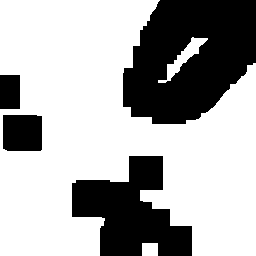

In [50]:
Image.fromarray(np.uint8(mask.squeeze().numpy()*255))

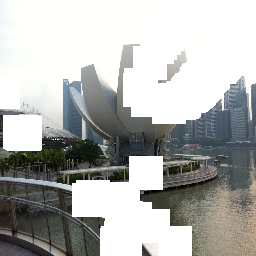

In [51]:
Image.fromarray(np.uint8(masked_img.squeeze().numpy()*255))

In [52]:
lc = iis.lossCompute
extractor = iis.vgg16extractor.to('cpu')

In [53]:
masked_img.shape, mask.shape, image.shape

(torch.Size([1, 256, 256, 3]),
 torch.Size([1, 256, 256, 3]),
 torch.Size([1, 256, 256, 3]))

In [54]:
lc.loss_hole(mask, image, masked_img)

tensor([0.1171], dtype=torch.float64)

In [55]:
lc.loss_valid(mask, mask, image)

tensor([0.3065], dtype=torch.float64)

In [56]:
vgg_gt = extractor(image.transpose(1, 3).type(torch.FloatTensor))
vgg_out = extractor(masked_img.transpose(1, 3).type(torch.FloatTensor))

In [57]:
lc.loss_style(vgg_gt, vgg_out)

tensor([0.0031])

In [58]:
[x.shape for x in vgg_gt]

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32])]

In [59]:
ls_fn = lc.loss_total(mask.type(torch.float).transpose(1, 3), hparams.loss_factors)

In [60]:
image.transpose(1, 3).type(torch.FloatTensor).shape

torch.Size([1, 3, 256, 256])

In [61]:
masked_img.transpose(1, 3).type(torch.FloatTensor).shape

torch.Size([1, 3, 256, 256])

In [62]:
loss, dict_losses = ls_fn(image.transpose(1, 3).type(torch.FloatTensor), masked_img.transpose(1, 3).type(torch.FloatTensor))

D:\NewRepos\Image-Inpainting\loss\loss_compute.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dilated_mask = torch.tensor(dilated_mask> 0, dtype=torch.float, requires_grad=False).to(self.device)


In [63]:
loss

tensor([1.5613])

In [64]:
dict_losses

{'loss_hole': tensor([0.7025]),
 'loss_valid': tensor([0.]),
 'loss_perceptual': tensor([0.1100]),
 'loss_style_out': tensor([0.3734]),
 'loss_style_comp': tensor([0.3734]),
 'loss_tv': tensor([0.0019])}

In [65]:
{**dict_losses, **{"y":0}}

{'loss_hole': tensor([0.7025]),
 'loss_valid': tensor([0.]),
 'loss_perceptual': tensor([0.1100]),
 'loss_style_out': tensor([0.3734]),
 'loss_style_comp': tensor([0.3734]),
 'loss_tv': tensor([0.0019]),
 'y': 0}